# Step 2: Sentiment Signal Construction

In this notebook, we will build the sentiment regime signal (RISK-ON, NEUTRAL, RISK-OFF) using the Kasi Consumer Confidence Index (CCI).

**Goal:** For each month, label the sentiment regime based on CCI percentiles and add this as a new column to our dataset.

---

## 0. Imports and Data Loading

importing the necessary libraries and load the prepared data.

In [4]:
import pandas as pd
import numpy as np

# Load the prepared data
data_path = '../data/interim/backtest_data.csv'
df = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')
df.head()

,Top 40 TR,Healthcare Index,Telcos,Consumer Staples,Consumer Discretionary,Industrials,Financials,ALSI Total Return,CCI
Date,,,,,,,,,
2016-02-29,-0.471455,0.230367,-4.990919,-0.555268,-5.320210,-2.374335,-0.740200,0.584939,2.0
2016-03-31,6.437999,6.631171,3.504284,2.268919,12.267244,5.926069,8.132810,6.595622,2.0
2016-04-30,0.635799,3.722801,14.030166,-4.101525,-3.780188,-1.672751,2.062014,1.553764,2.0
2016-05-31,3.472426,-1.104561,-11.826468,6.908385,9.787054,4.820814,-0.509530,2.213634,2.0
2016-06-30,-5.156580,2.362974,9.363555,-8.097107,-3.794800,-3.975072,-4.148642,-4.398189,2.0


## 1. Visualize and Explore CCI

Distribution and summary statistics of the CCI column.

count    119.000000
mean       4.823529
std       19.848429
min      -19.000000
25%       -5.500000
50%       -1.000000
75%       13.500000
max       53.000000
Name: CCI, dtype: float64


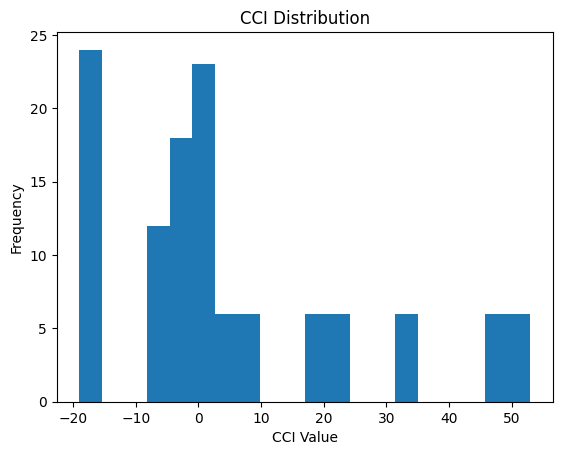

In [5]:
import matplotlib.pyplot as plt

cci = df['CCI']
print(cci.describe())
cci.plot(kind='hist', bins=20, title='CCI Distribution')
plt.xlabel('CCI Value')
plt.show()

## 2. Calculate CCI Regime Thresholds

We use the 33rd and 67th percentiles to define the regime boundaries.
- CCI < lower_threshold: RISK-OFF
- CCI > upper_threshold: RISK-ON
- Otherwise: NEUTRAL

Let's calculate these thresholds.

In [6]:
lower_threshold = np.percentile(cci, 33)
upper_threshold = np.percentile(cci, 67)
print(f'33rd percentile (RISK-OFF cutoff): {lower_threshold:.2f}')
print(f'67th percentile (RISK-ON cutoff): {upper_threshold:.2f}')

33rd percentile (RISK-OFF cutoff): -4.00
67th percentile (RISK-ON cutoff): 3.00


## 3. Assign Regimes to Each Month

labeling each month as RISK-ON, NEUTRAL, or RISK-OFF based on the CCI value.

In [8]:
# Assign regime labels based on CCI value and thresholds
def assign_regime(cci_value):
    if cci_value < lower_threshold:
        return 'RISK-OFF'
    elif cci_value > upper_threshold:
        return 'RISK-ON'
    else:
        return 'NEUTRAL'

# Apply the function to the CCI column
df['Regime'] = df['CCI'].apply(assign_regime)
df[['CCI', 'Regime']].head(12)


,CCI,Regime
Date,,
2016-02-29,2.0,NEUTRAL
2016-03-31,2.0,NEUTRAL
2016-04-30,2.0,NEUTRAL
2016-05-31,2.0,NEUTRAL
2016-06-30,2.0,NEUTRAL
2016-07-31,22.0,RISK-ON
2016-08-31,22.0,RISK-ON
2016-09-30,22.0,RISK-ON
2016-10-31,22.0,RISK-ON


## 4. Calculating 6-Month Momentum for Each Index


In [9]:
# List of index columns (excluding CCI and Regime)
index_columns = [col for col in df.columns if col not in ['CCI', 'Regime']]

# Calculate 6-month rolling sum of returns for each index
for col in index_columns:
    df[f'{col}_Momentum'] = df[col].rolling(window=6).sum()

# Show the first few rows with new momentum columns
momentum_cols = [f'{col}_Momentum' for col in index_columns]
df[['Regime'] + momentum_cols].head(10)


,Regime,Top 40 TR_Momentum,Healthcare Index_Momentum,Telcos_Momentum,Consumer Staples_Momentum,Consumer Discretionary_Momentum,Industrials_Momentum,Financials_Momentum,ALSI Total Return_Momentum
Date,,,,,,,,,
2016-02-29,NEUTRAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-31,NEUTRAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-30,NEUTRAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-31,NEUTRAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-30,NEUTRAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-31,RISK-ON,5.733647,15.178286,10.313039,-6.947201,12.368233,3.081688,8.279695,8.790476
2016-08-31,RISK-ON,8.516940,14.097719,5.759842,-3.704084,22.809322,7.589397,7.678623,9.866254
2016-09-30,RISK-ON,-0.254074,-1.996608,-0.438087,-10.547401,8.382738,-2.051533,-1.051663,0.972027
2016-10-31,RISK-ON,-3.234124,-8.945143,-17.906224,-7.511919,9.624632,-2.473661,-5.151545,-2.672358


## 5. Creating Portfolio Allocation Weights

In [10]:
# Define eligible indices for each regime
risk_on_indices = ['Top 40 TR', 'Telcos', 'Consumer Discretionary', 'Industrials']
risk_off_indices = ['Healthcare Index', 'Financials', 'Consumer Staples', 'Telcos']
neutral_indices = [col for col in df.columns if col not in ['CCI', 'Regime'] and not col.endswith('_Momentum')]

# Prepare a DataFrame to store weights
weights = pd.DataFrame(index=df.index, columns=neutral_indices)

for date, row in df.iterrows():
    regime = row['Regime']
    if regime == 'RISK-ON':
        eligible = risk_on_indices
    elif regime == 'RISK-OFF':
        eligible = risk_off_indices
    else:
        eligible = neutral_indices
    
    # Get momentum values for eligible indices
    momenta = [row[f'{col}_Momentum'] for col in eligible]
    # If all momenta are NaN or <=0, use equal weights
    if all((pd.isna(m) or m <= 0) for m in momenta):
        w = [1/len(eligible)] * len(eligible)
    else:
        # Set negative or NaN momenta to zero
        momenta = [m if (not pd.isna(m) and m > 0) else 0 for m in momenta]
        total = sum(momenta)
        if total == 0:
            w = [1/len(eligible)] * len(eligible)
        else:
            w = [m/total for m in momenta]
    # Assign weights
    for i, col in enumerate(eligible):
        weights.at[date, col] = w[i]
    # Set weights for ineligible indices to 0
    for col in set(neutral_indices) - set(eligible):
        weights.at[date, col] = 0

# Show the first few rows of weights
weights.head(10)

,Top 40 TR,Healthcare Index,Telcos,Consumer Staples,Consumer Discretionary,Industrials,Financials,ALSI Total Return
Date,,,,,,,,
2016-02-29,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
2016-03-31,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
2016-04-30,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
2016-05-31,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
2016-06-30,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
2016-07-31,0.18204,0,0.327433,0,0.392685,0.097842,0,0
2016-08-31,0.19064,0,0.128926,0,0.510555,0.169878,0,0
2016-09-30,0.0,0,0.0,0,1.0,0.0,0,0
2016-10-31,0.0,0,0.0,0,1.0,0.0,0,0


## 6. Portfolio Returns

In [11]:
# Calculate portfolio returns by applying weights to index returns
portfolio_returns = (weights * df[weights.columns]).sum(axis=1)

# Store as a new column in the main DataFrame
df['Portfolio_Return'] = portfolio_returns

# Show the first few rows of the result
df[['Portfolio_Return'] + list(weights.columns)].head(10)

,Portfolio_Return,Top 40 TR,Healthcare Index,Telcos,Consumer Staples,Consumer Discretionary,Industrials,Financials,ALSI Total Return
Date,,,,,,,,,
2016-02-29,-1.704635,-0.471455,0.230367,-4.990919,-0.555268,-5.320210,-2.374335,-0.740200,0.584939
2016-03-31,6.470515,6.437999,6.631171,3.504284,2.268919,12.267244,5.926069,8.132810,6.595622
2016-04-30,1.55626,0.635799,3.722801,14.030166,-4.101525,-3.780188,-1.672751,2.062014,1.553764
2016-05-31,1.720219,3.472426,-1.104561,-11.826468,6.908385,9.787054,4.820814,-0.509530,2.213634
2016-06-30,-2.230483,-5.156580,2.362974,9.363555,-8.097107,-3.794800,-3.975072,-4.148642,-4.398189
2016-07-31,1.519652,0.815459,3.335534,0.232421,-3.370606,3.209133,0.356963,3.483242,2.240707
2016-08-31,2.187149,2.311837,-0.850200,-9.544116,2.687849,5.120879,2.133374,-1.341272,1.660716
2016-09-30,-2.15934,-2.333014,-9.463155,-2.693646,-4.574398,-2.159340,-3.714861,-0.597476,-2.298605
2016-10-31,-2.538295,-2.344252,-3.225734,-3.437971,-1.066042,-2.538295,-2.094879,-2.037867,-2.090621


## 7. Performance Analysis & Visualization

In this section, we'll evaluate the performance of our sentiment-driven strategy versus the ALSI benchmark. We'll cover:

1. Cumulative returns comparison

2. Rolling 12-month returns

3. Drawdowns

4. Volatility comparison

5. Regime timeline

6. Correlation with ALSI

7. Sharpe ratio and summary stats

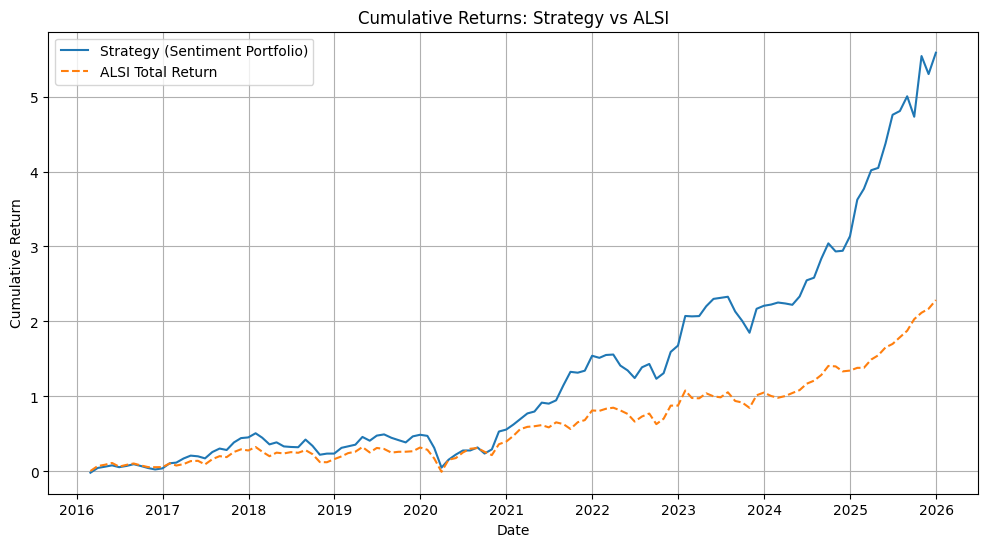

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure returns are in decimal form for compounding (e.g., 6.5% -> 0.065)
df['Portfolio_Return_Dec'] = df['Portfolio_Return'] / 100
df['ALSI_Return_Dec'] = df['ALSI Total Return'] / 100

# Calculate cumulative returns
cumulative_portfolio = (1 + df['Portfolio_Return_Dec']).cumprod() - 1
cumulative_alsi = (1 + df['ALSI_Return_Dec']).cumprod() - 1

plt.figure(figsize=(12,6))
plt.plot(cumulative_portfolio, label='Strategy (Sentiment Portfolio)')
plt.plot(cumulative_alsi, label='ALSI Total Return', linestyle='--')
plt.title('Cumulative Returns: Strategy vs ALSI')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

### Rolling 12-Month Returns

Plotting the rolling 12-month (1-year) returns for both the strategy and ALSI. This shows how performance changes over time.

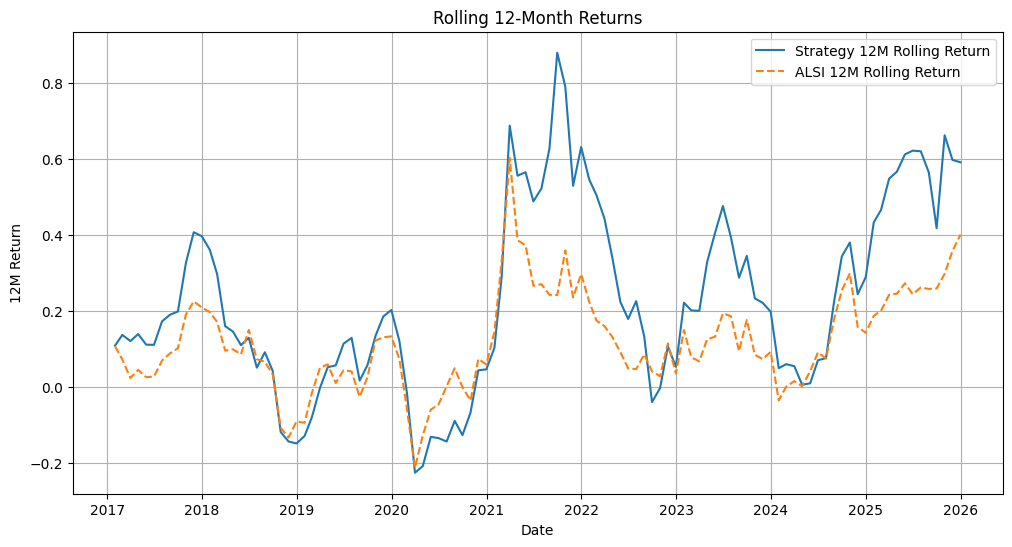

In [13]:
# Calculate rolling 12-month returns (compound)
rolling_12m_portfolio = (1 + df['Portfolio_Return_Dec']).rolling(window=12).apply(np.prod, raw=True) - 1
rolling_12m_alsi = (1 + df['ALSI_Return_Dec']).rolling(window=12).apply(np.prod, raw=True) - 1

plt.figure(figsize=(12,6))
plt.plot(rolling_12m_portfolio, label='Strategy 12M Rolling Return')
plt.plot(rolling_12m_alsi, label='ALSI 12M Rolling Return', linestyle='--')
plt.title('Rolling 12-Month Returns')
plt.ylabel('12M Return')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

### Drawdowns

Drawdown measures the decline from a historical peak. Let's visualize drawdowns for both the strategy and ALSI.

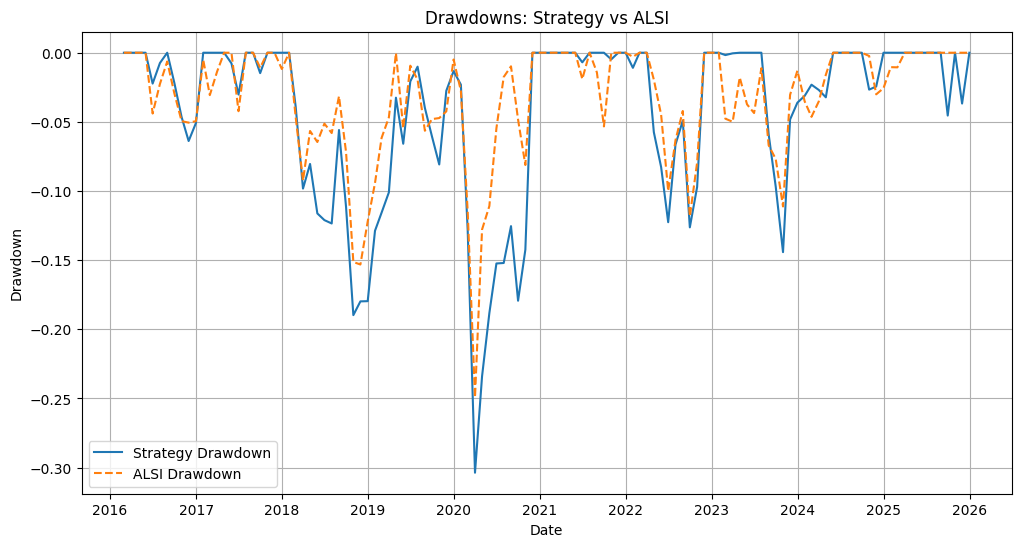

In [14]:
# Calculate drawdowns
def calculate_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown

drawdown_portfolio = calculate_drawdown(1 + cumulative_portfolio)
drawdown_alsi = calculate_drawdown(1 + cumulative_alsi)

plt.figure(figsize=(12,6))
plt.plot(drawdown_portfolio, label='Strategy Drawdown')
plt.plot(drawdown_alsi, label='ALSI Drawdown', linestyle='--')
plt.title('Drawdowns: Strategy vs ALSI')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

### Volatility Comparison

Comparing the rolling 12-month volatility (standard deviation of monthly returns) for the strategy and ALSI.

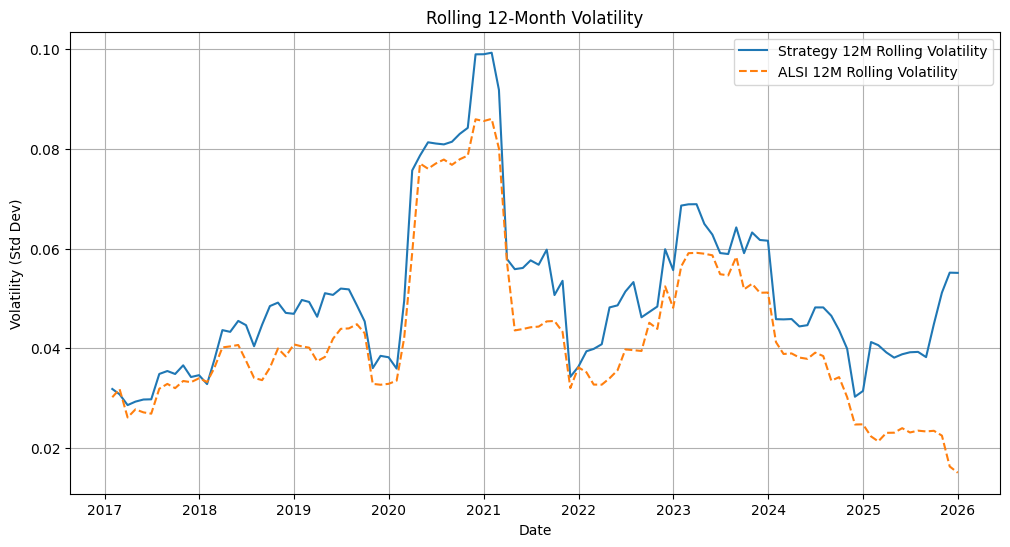

In [15]:
# Calculate rolling 12-month volatility (standard deviation)
vol_12m_portfolio = df['Portfolio_Return_Dec'].rolling(window=12).std()
vol_12m_alsi = df['ALSI_Return_Dec'].rolling(window=12).std()

plt.figure(figsize=(12,6))
plt.plot(vol_12m_portfolio, label='Strategy 12M Rolling Volatility')
plt.plot(vol_12m_alsi, label='ALSI 12M Rolling Volatility', linestyle='--')
plt.title('Rolling 12-Month Volatility')
plt.ylabel('Volatility (Std Dev)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

### Regime Timeline

Visualize the risk-on, neutral, and risk-off regimes over time.

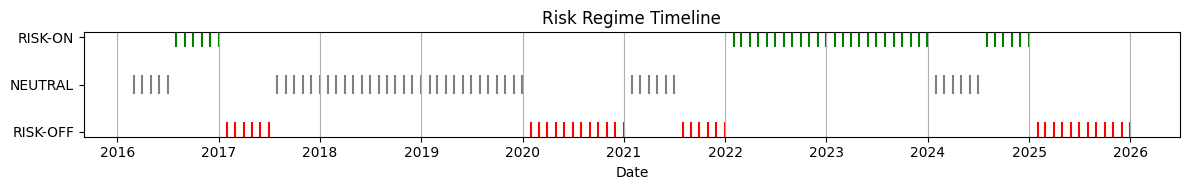

In [16]:
# Plot regime timeline
regime_colors = {'RISK-ON': 'green', 'NEUTRAL': 'gray', 'RISK-OFF': 'red'}
regime_numeric = df['Regime'].map({'RISK-ON': 1, 'NEUTRAL': 0, 'RISK-OFF': -1})

plt.figure(figsize=(12,2))
plt.scatter(df.index, regime_numeric, c=df['Regime'].map(regime_colors), marker='|', s=200)
plt.yticks([-1, 0, 1], ['RISK-OFF', 'NEUTRAL', 'RISK-ON'])
plt.title('Risk Regime Timeline')
plt.xlabel('Date')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

### Correlation with ALSI

Calculate and plot the rolling correlation between the strategy and ALSI returns.

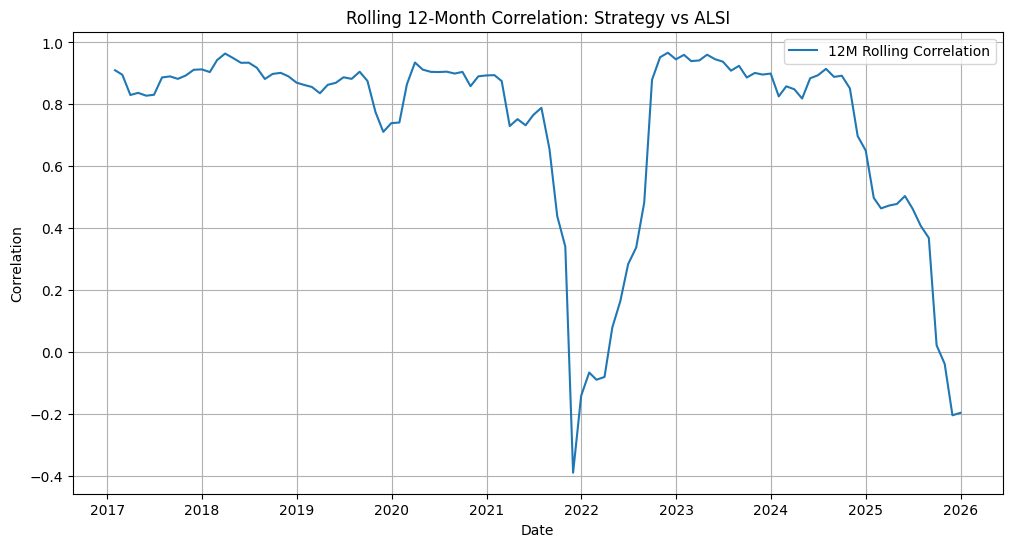

In [17]:
# Calculate rolling 12-month correlation
rolling_corr = df['Portfolio_Return_Dec'].rolling(window=12).corr(df['ALSI_Return_Dec'])

plt.figure(figsize=(12,6))
plt.plot(rolling_corr, label='12M Rolling Correlation')
plt.title('Rolling 12-Month Correlation: Strategy vs ALSI')
plt.ylabel('Correlation')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

### Let us look at Sector Correlation & Significance Analysis

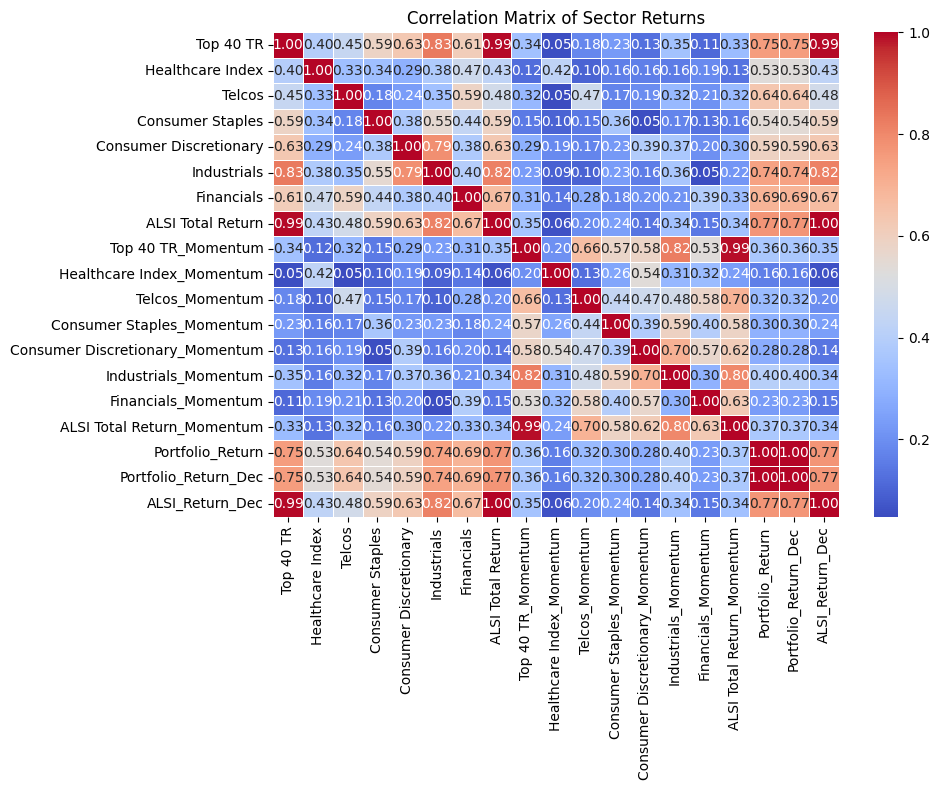

Correlation of each sector with Portfolio_Return


Portfolio_Return_Dec               1.000000
Portfolio_Return                   1.000000
ALSI_Return_Dec                    0.771041
ALSI Total Return                  0.771041
Top 40 TR                          0.752530
Industrials                        0.741109
Financials                         0.693539
Telcos                             0.636433
Consumer Discretionary             0.593840
Consumer Staples                   0.544162
Healthcare Index                   0.534432
Industrials_Momentum               0.402121
ALSI Total Return_Momentum         0.370382
Top 40 TR_Momentum                 0.364881
Telcos_Momentum                    0.322077
Consumer Staples_Momentum          0.296593
Consumer Discretionary_Momentum    0.279099
Financials_Momentum                0.232503
Healthcare Index_Momentum          0.160652
dtype: float64

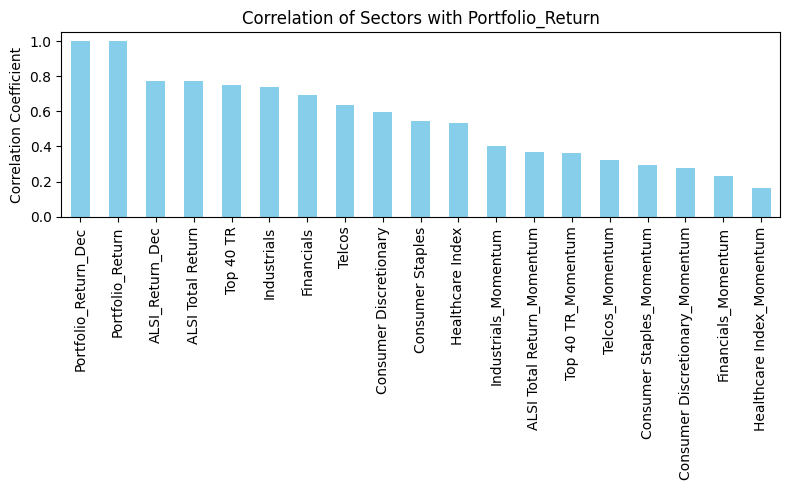


Most significant variable: Portfolio_Return_Dec (correlation = 1.00)


In [18]:
# --- Sector Correlation & Significance Analysis ---
import seaborn as sns
import matplotlib.pyplot as plt

sector_cols = [col for col in df.columns if col not in ['CCI', 'Regime']]
sector_returns = df[sector_cols]

# 1. Correlation Matrix for Sector Returns
corr_matrix = sector_returns.corr()
plt.figure(figsize=(10, 8))
1
40
12
14
0.8
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Sector Returns')
plt.tight_layout()
plt.show()

# 2. Significance of Variables (Correlation with Portfolio Return)
if 'Portfolio_Return' in df.columns:
    target = 'Portfolio_Return'
else:
    target = 'ALSI Total Return'

correlations = sector_returns.corrwith(df[target])
correlations = correlations.sort_values(key=abs, ascending=False)

print('Correlation of each sector with', target)
display(correlations)

plt.figure(figsize=(8, 5))
correlations.plot(kind='bar', color='skyblue')
plt.title(f'Correlation of Sectors with {target}')
plt.ylabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

# Most significant variable (highest absolute correlation)
most_significant = correlations.index[0]
print(f'\nMost significant variable: {most_significant} (correlation = {correlations.iloc[0]:.2f})')

### Now we look at correlation of Sectors with ALSI

Correlation of each sector with ALSI Total Return


ALSI_Return_Dec                    1.000000
ALSI Total Return                  1.000000
Top 40 TR                          0.993823
Industrials                        0.815933
Portfolio_Return_Dec               0.771041
Portfolio_Return                   0.771041
Financials                         0.667305
Consumer Discretionary             0.629206
Consumer Staples                   0.587926
Telcos                             0.480467
Healthcare Index                   0.426875
Top 40 TR_Momentum                 0.352730
Industrials_Momentum               0.344324
ALSI Total Return_Momentum         0.342151
Consumer Staples_Momentum          0.239612
Telcos_Momentum                    0.195793
Financials_Momentum                0.146784
Consumer Discretionary_Momentum    0.138884
Healthcare Index_Momentum          0.061398
dtype: float64

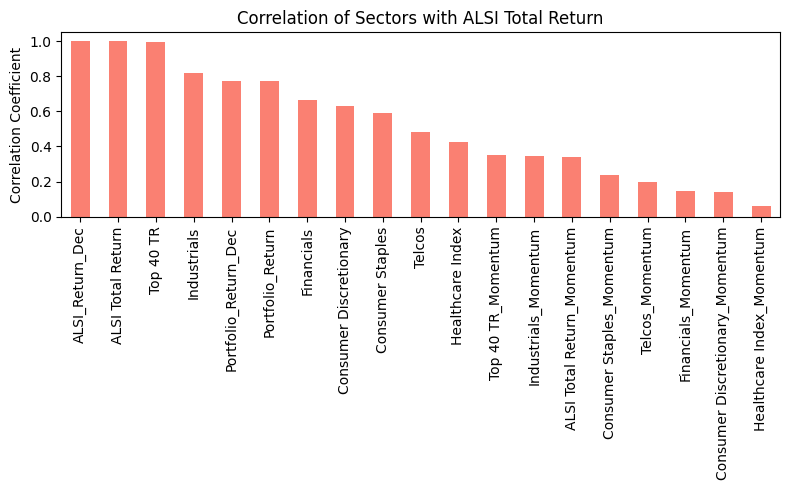


Most significant variable for ALSI: ALSI_Return_Dec (correlation = 1.00)


In [19]:
# --- Correlation of Sectors with ALSI ---
alsi_target = 'ALSI Total Return'
alsi_correlations = sector_returns.corrwith(df[alsi_target])
alsi_correlations = alsi_correlations.sort_values(key=abs, ascending=False)

print('Correlation of each sector with ALSI Total Return')
display(alsi_correlations)

plt.figure(figsize=(8, 5))
alsi_correlations.plot(kind='bar', color='salmon')
plt.title('Correlation of Sectors with ALSI Total Return')
plt.ylabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

# Most significant variable for ALSI
most_significant_alsi = alsi_correlations.index[0]
print(f'\nMost significant variable for ALSI: {most_significant_alsi} (correlation = {alsi_correlations.iloc[0]:.2f})')

### Sharpe Ratio & Summary Statistics

Let's calculate the annualized Sharpe ratio, total return, annualized volatility, and win rate for both the strategy and ALSI.

In [20]:
# Assume 12 periods per year (monthly data)
rf = 0  # risk-free rate (set to 0 for simplicity)
periods_per_year = 12

# Annualized Sharpe ratio
def annualized_sharpe(returns, rf=0):
    excess = returns - rf
    return (excess.mean() / excess.std()) * np.sqrt(periods_per_year)

# Total return
def total_return(returns):
    return (1 + returns).prod() - 1

# Annualized volatility
def annualized_vol(returns):
    return returns.std() * np.sqrt(periods_per_year)

# Win rate
def win_rate(returns):
    return (returns > 0).mean()

stats = {
    'Total Return': [total_return(df['Portfolio_Return_Dec']), total_return(df['ALSI_Return_Dec'])],
    'Annualized Volatility': [annualized_vol(df['Portfolio_Return_Dec']), annualized_vol(df['ALSI_Return_Dec'])],
    'Sharpe Ratio': [annualized_sharpe(df['Portfolio_Return_Dec']), annualized_sharpe(df['ALSI_Return_Dec'])],
    'Win Rate': [win_rate(df['Portfolio_Return_Dec']), win_rate(df['ALSI_Return_Dec'])]
}

summary = pd.DataFrame(stats, index=['Strategy', 'ALSI'])
display(summary)
summary

,Total Return,Annualized Volatility,Sharpe Ratio,Win Rate
Strategy,5.584302,0.184383,1.130044,0.672269
ALSI,2.285487,0.149721,0.879199,0.638655


,Total Return,Annualized Volatility,Sharpe Ratio,Win Rate
Strategy,5.584302,0.184383,1.130044,0.672269
ALSI,2.285487,0.149721,0.879199,0.638655
